In [ ]:
from earthformer.cuboid_transformer.cuboid_transformer import CuboidTransformerModel
import torch

# Optimized config for Landsat 3-timestep forecasting
landsat_config = {
    'input_shape': (3, 128, 128, 9),    # 3 input timesteps, 128x128, 9 Landsat bands
    'target_shape': (3, 128, 128, 1),   # 3 output timesteps
    
    # Small model for prototyping
    'base_units': 96,                    # Small but efficient
    'num_heads': 6,                      # Divisible by base_units
    'enc_depth': [2, 2],                 # 2-level hierarchy (sufficient for short sequences)
    'dec_depth': [1, 1],                 # Matching decoder depth
    
    # Dropout for better generalization during prototyping
    'attn_drop': 0.1,
    'proj_drop': 0.1,
    'ffn_drop': 0.1,
    
    # Global vectors for capturing Landsat scene patterns
    'num_global_vectors': 8,
    'use_dec_self_global': True,
    'use_dec_cross_global': True,
    
    # Optimized for satellite imagery
    'pos_embed_type': 't+hw',            # Separate temporal and spatial embeddings
    'use_relative_pos': True,            # Good for satellite spatial patterns
    'ffn_activation': 'gelu',            # Works well for vision tasks
    
    # Cuboid settings optimized for short temporal sequences
    'enc_cuboid_size': [(2, 4, 4), (2, 4, 4)],     # Small temporal cuboids for 3 timesteps
    'enc_cuboid_strategy': [('l', 'l', 'l'), ('d', 'd', 'd')],
    
    # Cross-attention settings for decoder
    'dec_cross_cuboid_hw': [(4, 4), (4, 4)],
    'dec_cross_n_temporal': [1, 2],      # Use 1-2 temporal frames for cross-attention
}

# Create model
model = CuboidTransformerModel(**landsat_config)
print(f"✓ Landsat model created! Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test with dummy Landsat data
batch_size = 4  # You can use larger batches with 40GB VRAM
dummy_landsat = torch.randn(batch_size, 3, 128, 128, 9)
print(f"Input shape: {dummy_landsat.shape}")

# Forward pass test
with torch.no_grad():
    output = model(dummy_landsat)
    print(f"Output shape: {output.shape}")
    print("✓ Forward pass successful!")

# Memory usage estimate
def estimate_memory_usage(model, input_shape, batch_size=1):
    model.eval()
    dummy_input = torch.randn(batch_size, *input_shape)
    
    # Rough memory estimate
    param_memory = sum(p.numel() * 4 for p in model.parameters()) / 1e9  # GB
    input_memory = dummy_input.numel() * 4 / 1e9  # GB
    
    print(f"Estimated memory usage:")
    print(f"  Parameters: {param_memory:.2f} GB")
    print(f"  Input (batch={batch_size}): {input_memory:.2f} GB")
    print(f"  Activation estimate: ~{param_memory * 2:.2f} GB")
    print(f"  Total estimate: ~{param_memory * 3 + input_memory:.2f} GB")

estimate_memory_usage(model, (3, 128, 128, 9), batch_size=8)

/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


🚀 Starting full GPU training...
✅ Found tiled dataset at ./Data/Dataset
Testing data module setup...
train split: 86 cities, 1351 tile sequences
val split: 19 cities, 212 tile sequences
✅ Training batches: 169
✅ Validation batches: 27
✅ Sample batch - Inputs: torch.Size([8, 3, 128, 128, 9]), Targets: torch.Size([8, 3, 128, 128, 1])


wandb: Currently logged in as: jesus-guerrero (jesus-guerrero-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model initialized with 9,036,109 parameters
Testing model with sample data...
✅ Model test - Output shape: torch.Size([8, 3, 128, 128, 1])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..



LANDSAT LST PREDICTION TRAINING - TILED DATASET
Dataset: ./Data/Dataset
  - Cities Tiles: ./Data/Dataset/Cities_Tiles
  - DEM Tiles: ./Data/Dataset/DEM_2014_Tiles
Batch size: 8
Max epochs: 50
Learning rate: 0.0002
Precision: 16-mixed
Devices: 1 GPU(s)
Num workers: 4
Experiment: landsat_full_training
Data limits: 100% train, 100% val
Checkpoints: ./checkpoints
Logs: ./logs
Wandb project: landsat-lst-forecasting
Wandb tags: ['full-training', 'production', 'earthformer', 'gpu']

🚀 Starting training...
train split: 86 cities, 1351 tile sequences
val split: 19 cities, 212 tile sequences


/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory ./checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | CuboidTransformerModel | 9.0 M 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
36.144    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=-0.2°F, Max=2.6°F, Mean=0.9°F
Error Statistics (Raw °F): MAE=97.00°F, RMSE=98.95°F, Bias=-96.96°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: -0.1, Max: 2.1, Mean: 1.1
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: -0.0, Max: 2.1, Mean: 1.1
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [119. 1

Training: 0it [00:00, ?it/s]

/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=139.0°F, Mean=111.8°F
Predicted LST Statistics (Raw): Min=-0.8°F, Max=3.1°F, Mean=1.0°F
Error Statistics (Raw °F): MAE=110.82°F, RMSE=112.04°F, Bias=-110.80°F
Sample 0: Raw LST values - Min: 99.0, Max: 136.0, Mean: 123.4
Center region LST values:
[[126. 126. 126. 125. 124.]
 [127. 126. 126. 126. 124.]
 [127. 126. 126. 126. 124.]
 [127. 126. 126. 126. 124.]
 [126. 126. 125. 125. 124.]]
Sample 0: Raw Prediction values - Min: -0.7, Max: 2.6, Mean: 1.0
Sample 1: Raw LST values - Min: 95.0, Max: 130.0, Mean: 117.8
Center region LST values:
[[121. 120. 120. 120. 121.]
 [120. 120. 120. 120. 121.]
 [120. 119. 119. 119. 121.]
 [119. 119. 119. 119. 120.]
 [119. 119. 119. 119. 120.]]
Sample 1: Raw Prediction values - Min: -0.4, Max: 2.6, Mean: 1.0
Sample 2: Raw LST values - Min: 94.0, Max: 137.0, Mean: 126.4
Center region LST values:
[[124. 123. 123. 123. 123.]
 [124. 123. 123. 123. 123.]
 [124. 123. 123. 123. 123.]
 [125. 124. 123. 123. 123.]
 [12

wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=4.2°F, Max=8.5°F, Mean=7.6°F
Error Statistics (Raw °F): MAE=90.60°F, RMSE=92.44°F, Bias=-90.31°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 4.2, Max: 8.5, Mean: 7.6
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 4.2, Max: 8.5, Mean: 7.6
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [119. 119.

Metric val_loss improved. New best score: 85.117
Epoch 0, global step 169: 'val_loss' reached 85.11744 (best 85.11744), saving model to './checkpoints/landsat_full_training-epoch=00-val_loss=85.117.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.404 >= min_delta = 0.0. New best score: 82.713
Epoch 1, global step 338: 'val_loss' reached 82.71344 (best 82.71344), saving model to './checkpoints/landsat_full_training-epoch=01-val_loss=82.713.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.739 >= min_delta = 0.0. New best score: 79.974
Epoch 2, global step 507: 'val_loss' reached 79.97420 (best 79.97420), saving model to './checkpoints/landsat_full_training-epoch=02-val_loss=79.974.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.056 >= min_delta = 0.0. New best score: 76.918
Epoch 3, global step 676: 'val_loss' reached 76.91803 (best 76.91803), saving model to './checkpoints/landsat_full_training-epoch=03-val_loss=76.918.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.341 >= min_delta = 0.0. New best score: 73.577
Epoch 4, global step 845: 'val_loss' reached 73.57712 (best 73.57712), saving model to './checkpoints/landsat_full_training-epoch=04-val_loss=73.577.ckpt' as top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=143.0°F, Mean=108.5°F
Predicted LST Statistics (Raw): Min=16.4°F, Max=21.9°F, Mean=19.4°F
Error Statistics (Raw °F): MAE=89.30°F, RMSE=91.72°F, Bias=-89.03°F
Sample 0: Raw LST values - Min: 113.0, Max: 123.0, Mean: 117.2
Center region LST values:
[[116. 116. 116. 117. 117.]
 [117. 117. 117. 117. 117.]
 [117. 117. 117. 118. 118.]
 [117. 117. 117. 118. 118.]
 [117. 118. 118. 118. 118.]]
Sample 0: Raw Prediction values - Min: 16.6, Max: 20.4, Mean: 19.4
Sample 1: Raw LST values - Min: 96.0, Max: 104.0, Mean: 100.3
Center region LST values:
[[98. 99. 99. 98. 98.]
 [98. 99. 98. 98. 98.]
 [98. 99. 98. 98. 98.]
 [98. 98. 98. 98. 98.]
 [98. 98. 98. 98. 98.]]
Sample 1: Raw Prediction values - Min: 16.8, Max: 20.1, Mean: 19.4
Sample 2: Raw LST values - Min: 111.0, Max: 134.0, Mean: 129.4
Center region LST values:
[[129. 129. 129. 130. 130.]
 [129. 129. 129. 130. 130.]
 [129. 129. 129. 129. 129.]
 [129. 128. 128. 129. 129.]
 [128. 128. 128. 128. 12

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=17.5°F, Max=27.3°F, Mean=23.1°F
Error Statistics (Raw °F): MAE=75.67°F, RMSE=77.33°F, Bias=-74.79°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 18.5, Max: 24.1, Mean: 23.1
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 18.6, Max: 24.1, Mean: 23.1
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [

Metric val_loss improved by 3.598 >= min_delta = 0.0. New best score: 69.979
Epoch 5, global step 1014: 'val_loss' reached 69.97928 (best 69.97928), saving model to './checkpoints/landsat_full_training-epoch=05-val_loss=69.979.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.812 >= min_delta = 0.0. New best score: 66.167
Epoch 6, global step 1183: 'val_loss' reached 66.16698 (best 66.16698), saving model to './checkpoints/landsat_full_training-epoch=06-val_loss=66.167.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.034 >= min_delta = 0.0. New best score: 62.133
Epoch 7, global step 1352: 'val_loss' reached 62.13335 (best 62.13335), saving model to './checkpoints/landsat_full_training-epoch=07-val_loss=62.133.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.166 >= min_delta = 0.0. New best score: 57.968
Epoch 8, global step 1521: 'val_loss' reached 57.96751 (best 57.96751), saving model to './checkpoints/landsat_full_training-epoch=08-val_loss=57.968.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.285 >= min_delta = 0.0. New best score: 53.683
Epoch 9, global step 1690: 'val_loss' reached 53.68297 (best 53.68297), saving model to './checkpoints/landsat_full_training-epoch=09-val_loss=53.683.ckpt' as top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=139.0°F, Mean=108.1°F
Predicted LST Statistics (Raw): Min=33.2°F, Max=45.3°F, Mean=40.1°F
Error Statistics (Raw °F): MAE=68.24°F, RMSE=70.64°F, Bias=-67.96°F
Sample 0: Raw LST values - Min: 100.0, Max: 123.0, Mean: 113.9
Center region LST values:
[[115. 116. 116. 115. 115.]
 [116. 116. 115. 115. 115.]
 [116. 116. 115. 115. 115.]
 [116. 116. 115. 115. 115.]
 [116. 116. 115. 115. 115.]]
Sample 0: Raw Prediction values - Min: 33.4, Max: 42.0, Mean: 40.2
Sample 1: Raw LST values - Min: 128.0, Max: 139.0, Mean: 133.6
Center region LST values:
[[131. 131. 131. 131. 132.]
 [131. 131. 131. 131. 132.]
 [131. 131. 131. 131. 132.]
 [132. 132. 132. 132. 132.]
 [132. 132. 132. 132. 132.]]
Sample 1: Raw Prediction values - Min: 35.5, Max: 41.1, Mean: 40.2
Sample 2: Raw LST values - Min: 87.0, Max: 126.0, Mean: 104.1
Center region LST values:
[[117. 118. 117. 117. 116.]
 [117. 118. 117. 117. 116.]
 [116. 117. 117. 117. 116.]
 [115. 116. 116. 117. 117.]

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=38.2°F, Max=50.0°F, Mean=44.8°F
Error Statistics (Raw °F): MAE=54.82°F, RMSE=56.62°F, Bias=-53.11°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 38.8, Max: 47.4, Mean: 44.8
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 38.8, Max: 46.9, Mean: 44.8
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [

Metric val_loss improved by 4.358 >= min_delta = 0.0. New best score: 49.325
Epoch 10, global step 1859: 'val_loss' reached 49.32534 (best 49.32534), saving model to './checkpoints/landsat_full_training-epoch=10-val_loss=49.325.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.321 >= min_delta = 0.0. New best score: 45.004
Epoch 11, global step 2028: 'val_loss' reached 45.00415 (best 45.00415), saving model to './checkpoints/landsat_full_training-epoch=11-val_loss=45.004.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.411 >= min_delta = 0.0. New best score: 40.594
Epoch 12, global step 2197: 'val_loss' reached 40.59361 (best 40.59361), saving model to './checkpoints/landsat_full_training-epoch=12-val_loss=40.594.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.253 >= min_delta = 0.0. New best score: 36.340
Epoch 13, global step 2366: 'val_loss' reached 36.34027 (best 36.34027), saving model to './checkpoints/landsat_full_training-epoch=13-val_loss=36.340.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.079 >= min_delta = 0.0. New best score: 32.261
Epoch 14, global step 2535: 'val_loss' reached 32.26127 (best 32.26127), saving model to './checkpoints/landsat_full_training-epoch=14-val_loss=32.261.ckpt' as top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=140.0°F, Mean=112.7°F
Predicted LST Statistics (Raw): Min=55.9°F, Max=68.1°F, Mean=63.9°F
Error Statistics (Raw °F): MAE=53.55°F, RMSE=56.22°F, Bias=-48.73°F
Sample 0: Raw LST values - Min: 120.0, Max: 135.0, Mean: 130.4
Center region LST values:
[[130. 130. 130. 130. 131.]
 [130. 130. 130. 130. 131.]
 [130. 130. 130. 130. 131.]
 [130. 130. 130. 130. 131.]
 [130. 130. 130. 130. 131.]]
Sample 0: Raw Prediction values - Min: 56.0, Max: 65.2, Mean: 63.9
Sample 1: Raw LST values - Min: 83.0, Max: 115.0, Mean: 102.2
Center region LST values:
[[ 99.  98.  98.  98. 100.]
 [ 99.  99.  98.  99. 101.]
 [ 99.  99.  99.  99. 102.]
 [100. 100. 100. 100. 102.]
 [100. 101. 101. 101. 102.]]
Sample 1: Raw Prediction values - Min: 57.2, Max: 67.6, Mean: 63.9
Sample 2: Raw LST values - Min: 113.0, Max: 135.0, Mean: 126.3
Center region LST values:
[[129. 130. 130. 130. 130.]
 [129. 130. 130. 130. 130.]
 [129. 130. 130. 130. 130.]
 [130. 130. 130. 130. 130.]

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=60.2°F, Max=72.7°F, Mean=68.7°F
Error Statistics (Raw °F): MAE=31.92°F, RMSE=35.21°F, Bias=-29.25°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 60.9, Max: 71.1, Mean: 68.7
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 61.0, Max: 71.0, Mean: 68.7
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [

Metric val_loss improved by 3.816 >= min_delta = 0.0. New best score: 28.446
Epoch 15, global step 2704: 'val_loss' reached 28.44574 (best 28.44574), saving model to './checkpoints/landsat_full_training-epoch=15-val_loss=28.446.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.437 >= min_delta = 0.0. New best score: 25.009
Epoch 16, global step 2873: 'val_loss' reached 25.00866 (best 25.00866), saving model to './checkpoints/landsat_full_training-epoch=16-val_loss=25.009.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.808 >= min_delta = 0.0. New best score: 22.200
Epoch 17, global step 3042: 'val_loss' reached 22.20023 (best 22.20023), saving model to './checkpoints/landsat_full_training-epoch=17-val_loss=22.200.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.065 >= min_delta = 0.0. New best score: 20.135
Epoch 18, global step 3211: 'val_loss' reached 20.13542 (best 20.13542), saving model to './checkpoints/landsat_full_training-epoch=18-val_loss=20.135.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.603 >= min_delta = 0.0. New best score: 18.533
Epoch 19, global step 3380: 'val_loss' reached 18.53272 (best 18.53272), saving model to './checkpoints/landsat_full_training-epoch=19-val_loss=18.533.ckpt' as top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=139.0°F, Mean=112.9°F
Predicted LST Statistics (Raw): Min=72.0°F, Max=92.6°F, Mean=86.3°F
Error Statistics (Raw °F): MAE=29.57°F, RMSE=31.12°F, Bias=-26.64°F
Sample 0: Raw LST values - Min: 109.0, Max: 127.0, Mean: 120.1
Center region LST values:
[[122. 122. 122. 123. 123.]
 [121. 121. 122. 122. 123.]
 [121. 121. 121. 122. 122.]
 [121. 121. 121. 122. 122.]
 [121. 121. 122. 122. 122.]]
Sample 0: Raw Prediction values - Min: 75.7, Max: 89.9, Mean: 86.3
Sample 1: Raw LST values - Min: 120.0, Max: 139.0, Mean: 132.1
Center region LST values:
[[130. 130. 130. 130. 130.]
 [130. 130. 130. 130. 130.]
 [130. 130. 130. 130. 130.]
 [130. 130. 130. 130. 130.]
 [130. 130. 130. 130. 130.]]
Sample 1: Raw Prediction values - Min: 76.4, Max: 89.3, Mean: 86.3
Sample 2: Raw LST values - Min: 104.0, Max: 119.0, Mean: 112.5
Center region LST values:
[[115. 114. 114. 114. 114.]
 [115. 114. 114. 114. 113.]
 [115. 114. 114. 114. 113.]
 [114. 114. 113. 113. 113.

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=10.2°F, Max=117.1°F, Mean=88.9°F
Error Statistics (Raw °F): MAE=19.04°F, RMSE=25.27°F, Bias=-9.02°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 80.9, Max: 94.4, Mean: 90.2
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 80.1, Max: 94.2, Mean: 90.2
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.]
 [

Epoch 20, global step 3549: 'val_loss' reached 19.10810 (best 18.53272), saving model to './checkpoints/landsat_full_training-epoch=20-val_loss=19.108.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.495 >= min_delta = 0.0. New best score: 18.038
Epoch 21, global step 3718: 'val_loss' reached 18.03754 (best 18.03754), saving model to './checkpoints/landsat_full_training-epoch=21-val_loss=18.038.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 3887: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 4056: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 4225: 'val_loss' was not in top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=138.0°F, Mean=111.3°F
Predicted LST Statistics (Raw): Min=94.4°F, Max=106.1°F, Mean=102.4°F
Error Statistics (Raw °F): MAE=17.08°F, RMSE=20.19°F, Bias=-8.88°F
Sample 0: Raw LST values - Min: 83.0, Max: 115.0, Mean: 103.6
Center region LST values:
[[108. 108. 109. 110. 110.]
 [110. 110. 110. 111. 111.]
 [110. 110. 111. 111. 111.]
 [110. 110. 111. 111. 111.]
 [110. 110. 110. 111. 111.]]
Sample 0: Raw Prediction values - Min: 94.6, Max: 105.7, Mean: 102.4
Sample 1: Raw LST values - Min: 104.0, Max: 131.0, Mean: 120.3
Center region LST values:
[[126. 125. 125. 124. 124.]
 [126. 125. 125. 124. 124.]
 [126. 125. 125. 124. 124.]
 [126. 125. 124. 123. 123.]
 [126. 125. 124. 123. 123.]]
Sample 1: Raw Prediction values - Min: 94.6, Max: 105.6, Mean: 102.4
Sample 2: Raw LST values - Min: 97.0, Max: 115.0, Mean: 107.0
Center region LST values:
[[104. 103. 103. 102. 102.]
 [105. 104. 104. 103. 103.]
 [105. 105. 105. 104. 104.]
 [105. 105. 105. 105. 1

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=65.3°F, Max=135.8°F, Mean=104.2°F
Error Statistics (Raw °F): MAE=13.37°F, RMSE=21.92°F, Bias=6.32°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 93.3, Max: 106.1, Mean: 104.5
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 83.4, Max: 106.5, Mean: 104.5
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.

Epoch 25, global step 4394: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 4563: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 4732: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 4901: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 5070: 'val_loss' was not in top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=142.0°F, Mean=113.0°F
Predicted LST Statistics (Raw): Min=85.1°F, Max=117.6°F, Mean=109.7°F
Error Statistics (Raw °F): MAE=16.16°F, RMSE=19.99°F, Bias=-3.29°F
Sample 0: Raw LST values - Min: 109.0, Max: 134.0, Mean: 122.6
Center region LST values:
[[116. 115. 115. 115. 115.]
 [116. 115. 115. 115. 115.]
 [116. 115. 115. 115. 114.]
 [117. 116. 116. 116. 115.]
 [118. 116. 116. 116. 115.]]
Sample 0: Raw Prediction values - Min: 97.8, Max: 116.5, Mean: 109.7
Sample 1: Raw LST values - Min: 111.0, Max: 130.0, Mean: 125.1
Center region LST values:
[[125. 126. 126. 126. 126.]
 [125. 126. 126. 126. 126.]
 [125. 126. 126. 126. 126.]
 [126. 126. 126. 126. 127.]
 [126. 126. 127. 127. 127.]]
Sample 1: Raw Prediction values - Min: 100.8, Max: 113.0, Mean: 109.7
Sample 2: Raw LST values - Min: 112.0, Max: 138.0, Mean: 124.0
Center region LST values:
[[127. 127. 127. 127. 127.]
 [126. 126. 126. 127. 127.]
 [126. 126. 126. 127. 127.]
 [126. 126. 126. 127

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=51.5°F, Max=116.0°F, Mean=105.3°F
Error Statistics (Raw °F): MAE=13.19°F, RMSE=21.24°F, Bias=7.36°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 87.4, Max: 114.4, Mean: 107.9
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 85.7, Max: 114.2, Mean: 107.7
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118.

Epoch 30, global step 5239: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 5408: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 5577: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 5746: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 5915: 'val_loss' was not in top 3


Target LST Statistics (Raw TIFF): Min=0.0°F, Max=145.0°F, Mean=115.7°F
Predicted LST Statistics (Raw): Min=84.6°F, Max=118.1°F, Mean=111.2°F
Error Statistics (Raw °F): MAE=15.90°F, RMSE=25.59°F, Bias=-4.54°F
Sample 0: Raw LST values - Min: 126.0, Max: 135.0, Mean: 131.3
Center region LST values:
[[132. 132. 132. 132. 132.]
 [132. 132. 132. 132. 132.]
 [133. 133. 132. 133. 133.]
 [133. 133. 133. 133. 133.]
 [133. 133. 133. 133. 133.]]
Sample 0: Raw Prediction values - Min: 111.7, Max: 117.8, Mean: 114.3
Sample 1: Raw LST values - Min: 0.0, Max: 128.0, Mean: 55.5
Center region LST values:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Sample 1: Raw Prediction values - Min: 91.2, Max: 113.8, Mean: 99.9
Sample 2: Raw LST values - Min: 114.0, Max: 136.0, Mean: 129.5
Center region LST values:
[[132. 132. 132. 132. 131.]
 [132. 132. 132. 132. 131.]
 [132. 132. 132. 132. 131.]
 [132. 132. 132. 132. 131.]
 [131. 131. 131. 131. 131.]]
Sample 2: Raw Pre

Validation: 0it [00:00, ?it/s]

Target LST Statistics (Raw TIFF): Min=0.0°F, Max=123.0°F, Mean=97.9°F
Predicted LST Statistics (Raw): Min=84.1°F, Max=119.4°F, Mean=111.9°F
Error Statistics (Raw °F): MAE=14.73°F, RMSE=22.90°F, Bias=14.03°F
Sample 0: Raw LST values - Min: 97.0, Max: 118.0, Mean: 110.8
Center region LST values:
[[113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 114.]
 [113. 113. 113. 113. 113.]
 [113. 113. 113. 113. 113.]]
Sample 0: Raw Prediction values - Min: 94.4, Max: 117.2, Mean: 114.9
Sample 1: Raw LST values - Min: 86.0, Max: 109.0, Mean: 99.5
Center region LST values:
[[101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]
 [101. 101. 101. 101. 101.]]
Sample 1: Raw Prediction values - Min: 94.7, Max: 117.6, Mean: 114.5
Sample 2: Raw LST values - Min: 107.0, Max: 123.0, Mean: 117.4
Center region LST values:
[[119. 119. 119. 119. 119.]
 [119. 119. 119. 119. 119.]
 [119. 119. 119. 118. 118.]
 [119. 119. 119. 118. 118

Epoch 35, global step 6084: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 18.038. Signaling Trainer to stop.
Epoch 36, global step 6253: 'val_loss' was not in top 3
Restoring states from the checkpoint path at ./checkpoints/landsat_full_training-epoch=21-val_loss=18.038.ckpt



🧪 Running final test...
test split: 19 cities, 0 tile sequences


/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(

✅ Test completed: []

🎉 Training completed successfully!
📁 Best model saved to: ./checkpoints/landsat_full_training-epoch=21-val_loss=18.038.ckpt
🔗 View experiment at: https://wandb.ai/jesus-guerrero-ml/landsat-lst-forecasting/runs/79f3uqsr


/root/miniconda3/envs/earthformer15/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:153: UserWarning: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
  rank_zero_warn(


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
lr-AdamW,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,███▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▇███▇▇▆▆▅▅▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▂▁▂▁▂▂▁▁▁▁▁
train_mae_epoch,███▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae_step,██▇▇█▅▆▆▅▅▅▄▅▄▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_temp_mae_scaled,███▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_temp_rmse_scaled,███▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
val_correlation,▃▆▇▆▆▆▅▆▆▆▆▁▆▆▆▇▇▆▅▆▄▇▆▆▁▄▆▆▅▆▅▄▆▅▄█▆
val_loss,██▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▂▁▁▁▂


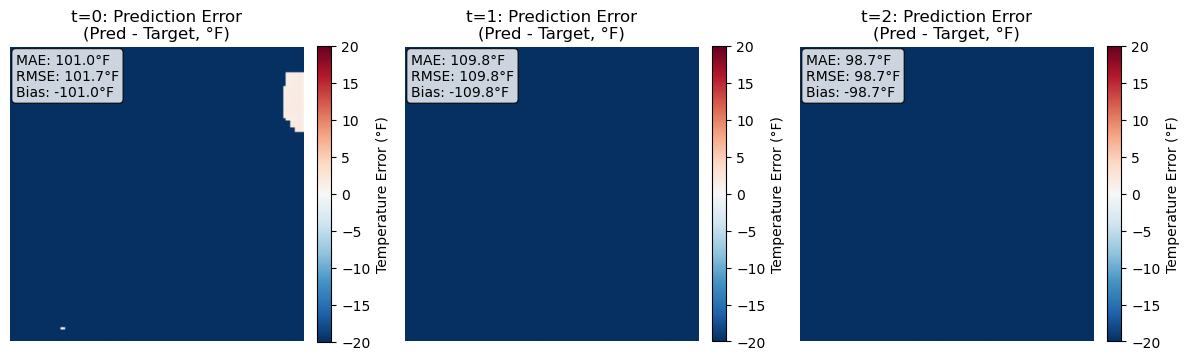

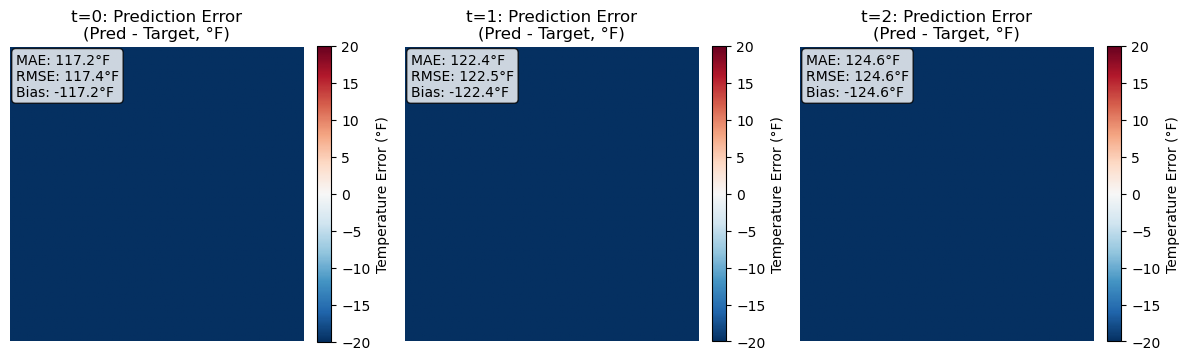

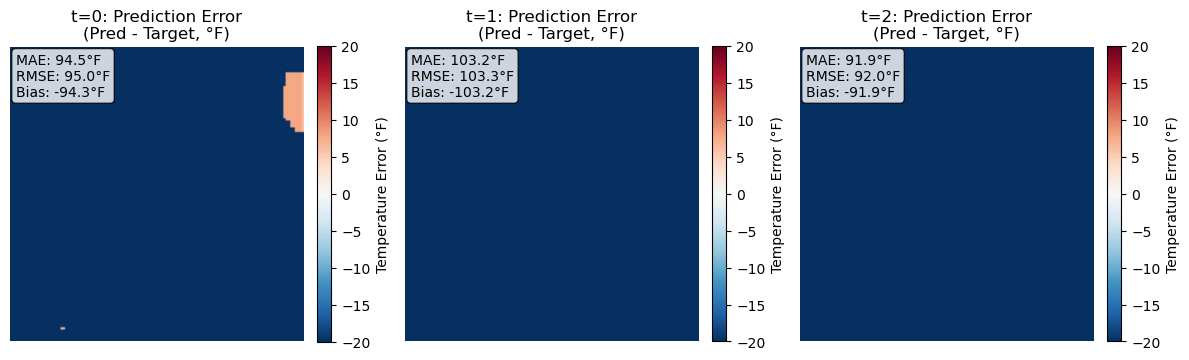

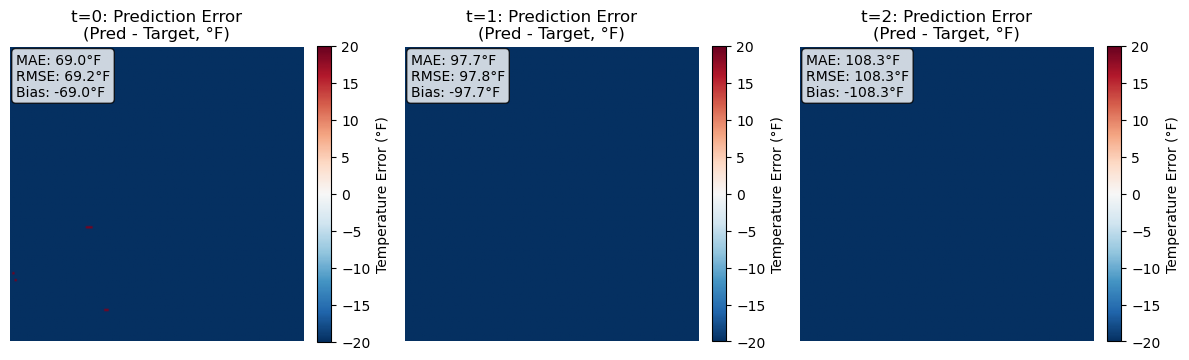

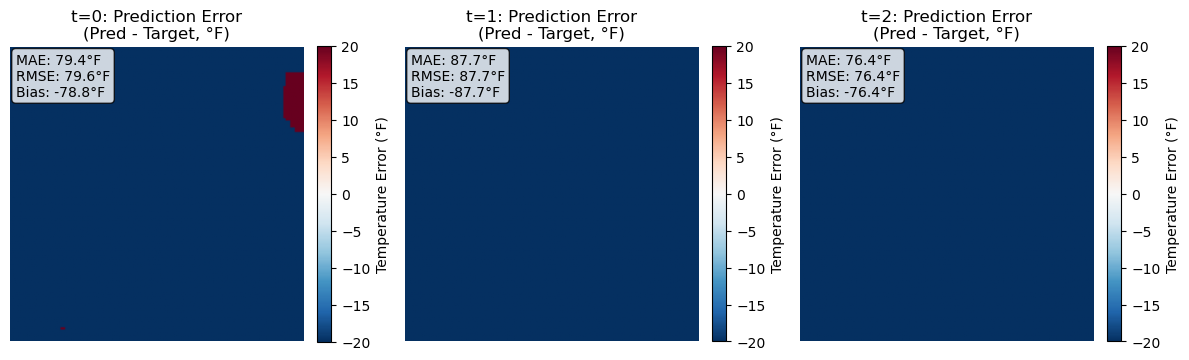

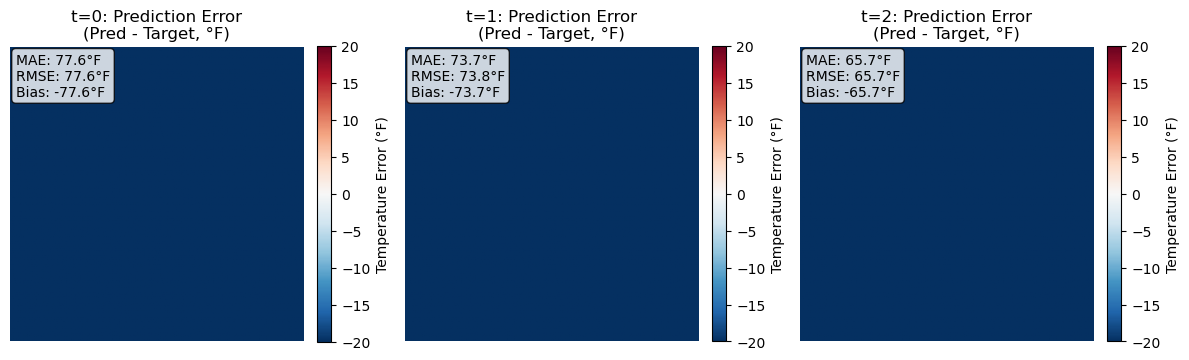

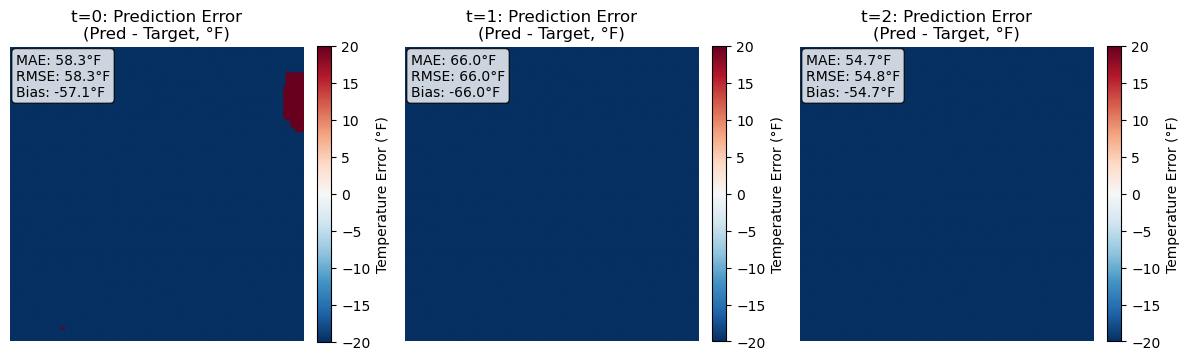

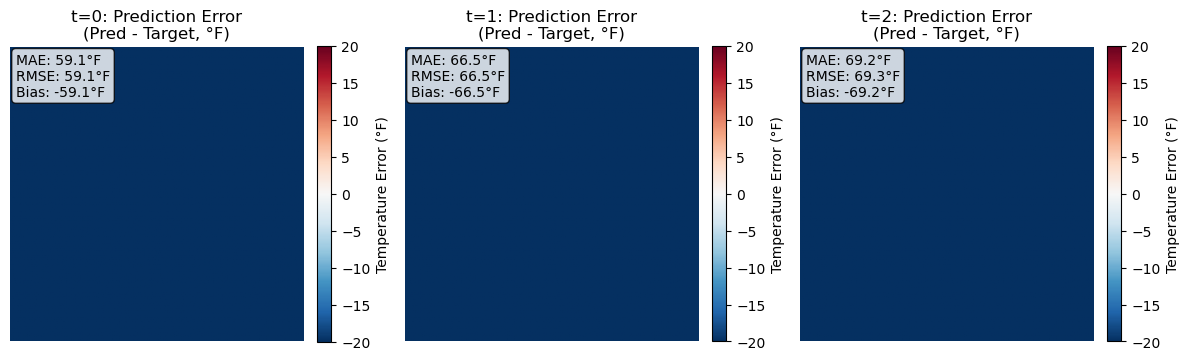

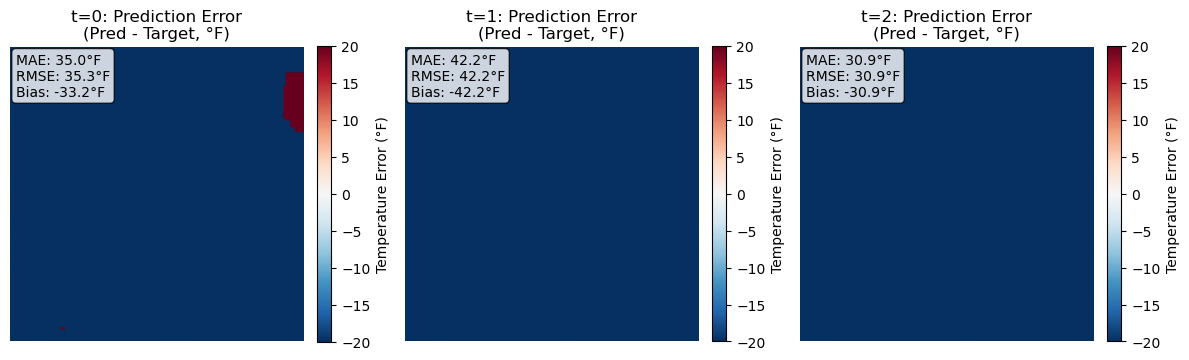

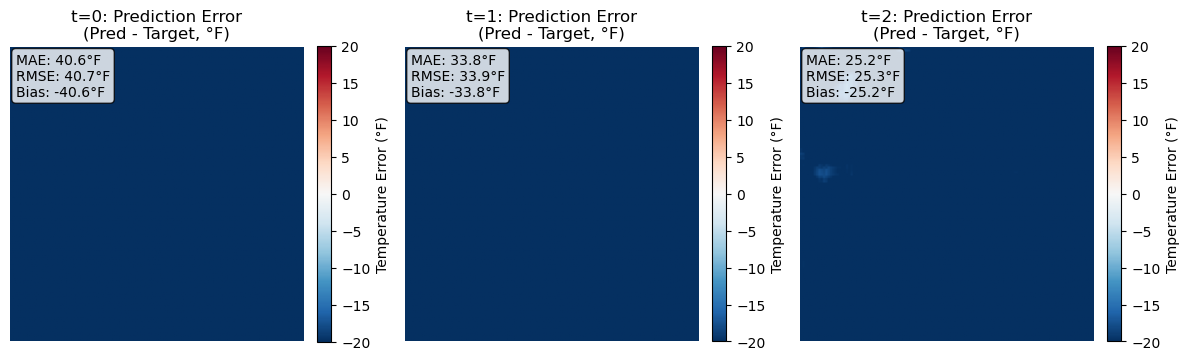

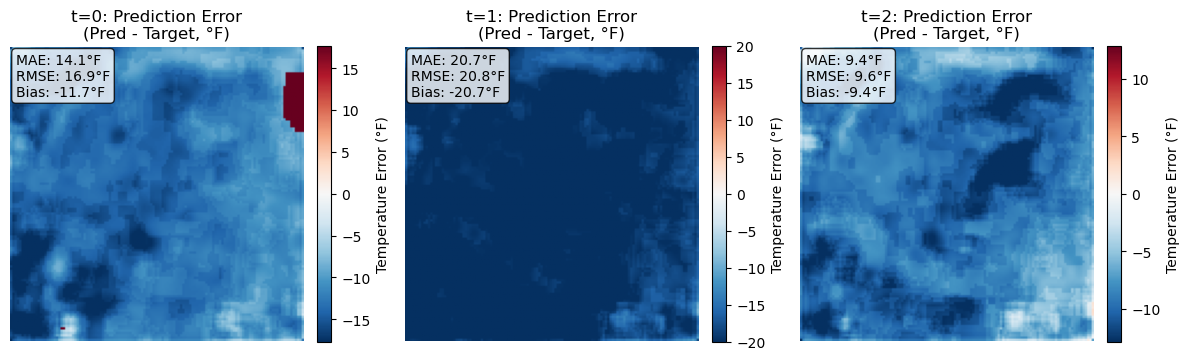

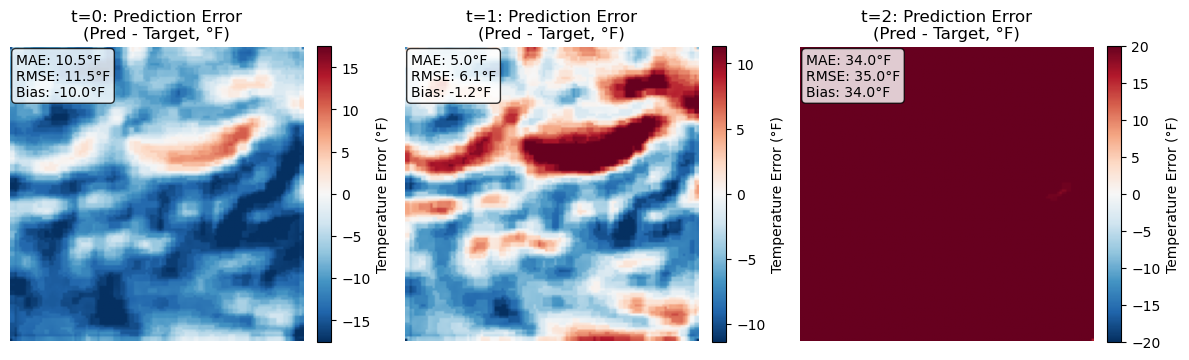

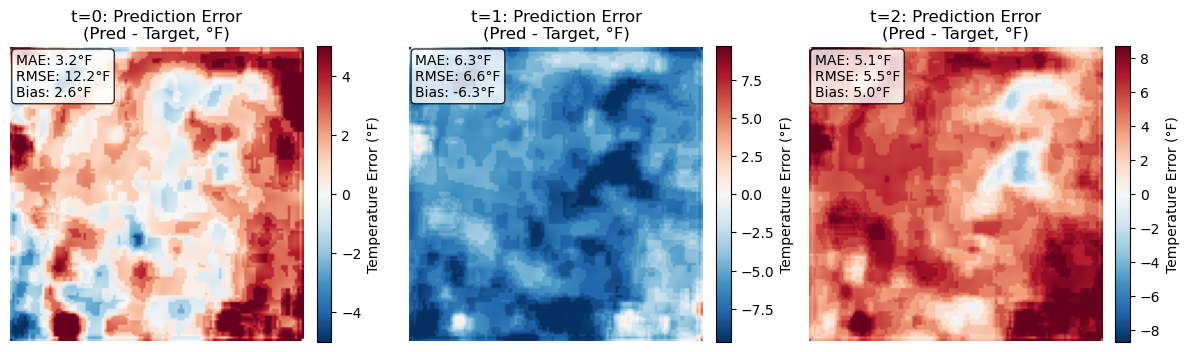

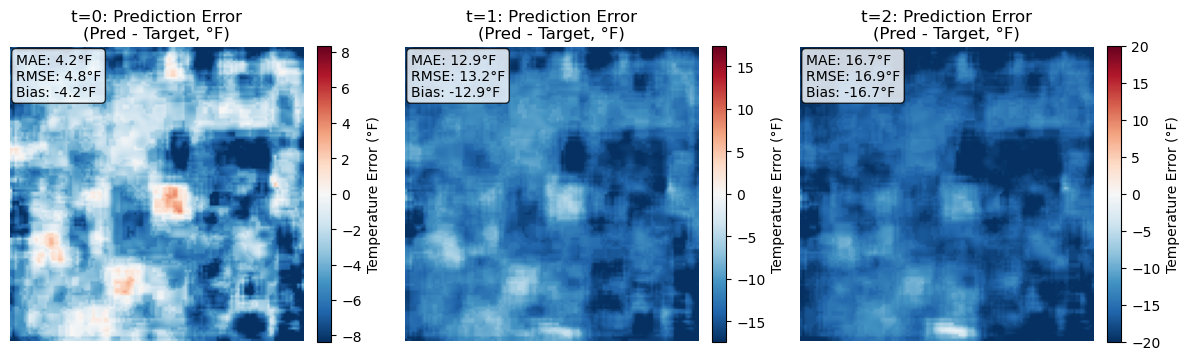

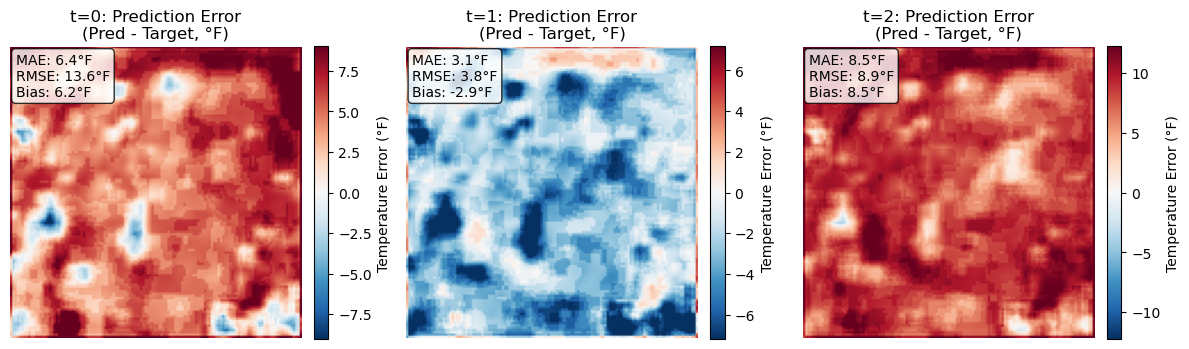

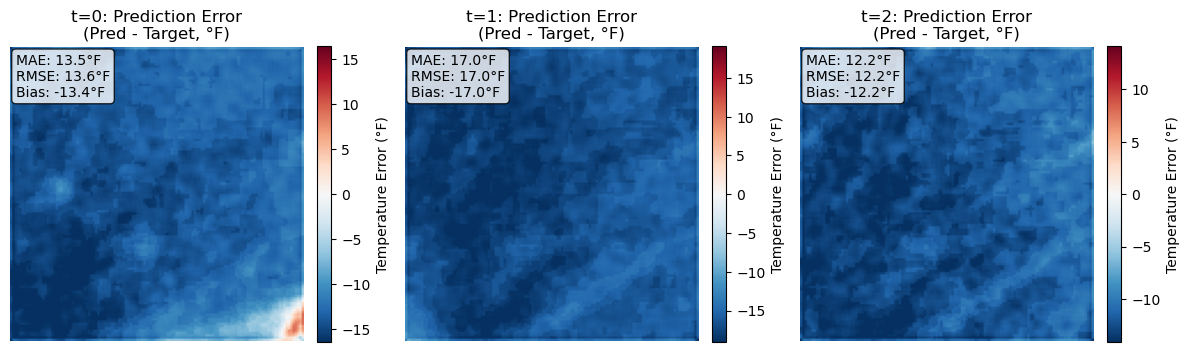

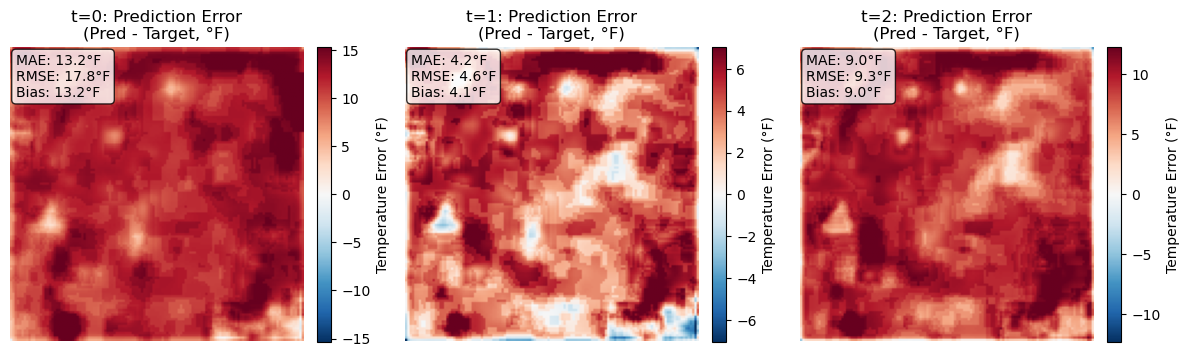

In [1]:
import os
import torch
from model import LandsatLSTPredictor
from dataset import LandsatDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import wandb

def train_landsat_model(
    dataset_root: str = "./Data/Dataset",
    batch_size: int = 4,
    max_epochs: int = 100,
    learning_rate: float = 1e-4,
    num_workers: int = 4,
    gpus: int = 1,
    precision: str = "32",  # Start with 32-bit precision for stability
    accumulate_grad_batches: int = 1,
    val_check_interval: float = 1.0,
    limit_train_batches: float = 1.0,
    limit_val_batches: float = 1.0,
    experiment_name: str = "landsat_lst_prediction",
    checkpoint_dir: str = "./checkpoints",
    log_dir: str = "./logs",
    wandb_project: str = "landsat-lst-forecasting",
    wandb_tags: list = None
):
    """
    Complete training pipeline for Landsat LST prediction
    
    Args:
        dataset_root: Path to preprocessed dataset with Cities_Tiles and DEM_2014_Tiles
        batch_size: Training batch size
        max_epochs: Maximum training epochs
        learning_rate: Initial learning rate
        num_workers: Number of data loading workers
        gpus: Number of GPUs to use
        precision: Training precision ('32', '16', or '16-mixed')
        accumulate_grad_batches: Gradient accumulation steps
        val_check_interval: Validation frequency
        limit_train_batches: Fraction of training data to use (for debugging)
        limit_val_batches: Fraction of validation data to use (for debugging)
        experiment_name: Name for logging
        checkpoint_dir: Directory to save checkpoints
        log_dir: Directory for logs
        wandb_project: Weights & Biases project name
        wandb_tags: List of tags for the experiment
    """
    
    # Set up default tags
    if wandb_tags is None:
        wandb_tags = ["landsat", "lstm-prediction", "earthformer"]
    
    # Create directories
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    
    # Verify tiled dataset exists
    dataset_path = os.path.join(dataset_root)
    cities_tiles = os.path.join(dataset_path, "Cities_Tiles")
    dem_tiles = os.path.join(dataset_path, "DEM_2014_Tiles")
    
    if not os.path.exists(cities_tiles):
        raise FileNotFoundError(f"Cities_Tiles directory not found at {cities_tiles}. Please run convert_to_tiles() first.")
    if not os.path.exists(dem_tiles):
        raise FileNotFoundError(f"DEM_2014_Tiles directory not found at {dem_tiles}. Please run convert_to_tiles() first.")
    
    print(f"✅ Found tiled dataset at {dataset_root}")
    
    # Initialize data module
    data_module = LandsatDataModule(
        dataset_root=dataset_root,
        batch_size=batch_size,
        num_workers=num_workers,
        sequence_length=3
    )
    
    # Test data module setup to catch issues early
    print("Testing data module setup...")
    try:
        data_module.setup("fit")
        train_loader = data_module.train_dataloader()
        val_loader = data_module.val_dataloader()
        
        print(f"✅ Training batches: {len(train_loader)}")
        print(f"✅ Validation batches: {len(val_loader)}")
        
        # Test one batch
        sample_batch = next(iter(train_loader))
        inputs, targets = sample_batch
        print(f"✅ Sample batch - Inputs: {inputs.shape}, Targets: {targets.shape}")
        
    except Exception as e:
        print(f"❌ Data module test failed: {e}")
        raise
    
    # Create comprehensive config for wandb
    config = {
        "batch_size": batch_size,
        "max_epochs": max_epochs,
        "learning_rate": learning_rate,
        "num_workers": num_workers,
        "precision": precision,
        "accumulate_grad_batches": accumulate_grad_batches,
        "val_check_interval": val_check_interval,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "dataset_root": dataset_root,
        "model_type": "CuboidTransformer",
        "input_shape": [3, 128, 128, 9],
        "target_shape": [3, 128, 128, 1],
        "sequence_length": 3,
        "train_batches": len(train_loader),
        "val_batches": len(val_loader),
        "total_train_samples": len(train_loader) * batch_size,
        "total_val_samples": len(val_loader) * batch_size,
    }
    
    # Initialize Weights & Biases logger
    logger = WandbLogger(
        project=wandb_project,
        name=experiment_name,
        tags=wandb_tags,
        config=config,
        save_dir=log_dir,
        log_model=True,  # Log model checkpoints to wandb
    )
    
    # Initialize model
    model = LandsatLSTPredictor(
        learning_rate=learning_rate,
        weight_decay=1e-5,
        warmup_steps=1000,
        max_epochs=max_epochs
    )
    
    # Test model with sample data
    print("Testing model with sample data...")
    try:
        model.eval()
        with torch.no_grad():
            test_output = model(inputs)
            print(f"✅ Model test - Output shape: {test_output.shape}")
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        raise
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename=f'{experiment_name}-{{epoch:02d}}-{{val_loss:.3f}}',
        save_top_k=3,
        monitor='val_loss',
        mode='min',
        save_last=True,
        verbose=True  # Added verbose for better feedback
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        verbose=True
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    # Trainer configuration
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if gpus > 0 else 'cpu',
        devices=gpus if gpus > 0 else None,
        # precision=precision,  # Re-enabled precision setting
        accumulate_grad_batches=accumulate_grad_batches,
        val_check_interval=val_check_interval,
        limit_train_batches=limit_train_batches,
        limit_val_batches=limit_val_batches,
        callbacks=[checkpoint_callback, early_stopping, lr_monitor],
        logger=logger,
        log_every_n_steps=50,
        enable_progress_bar=True,
        enable_model_summary=True,
        deterministic=False,  # Set to True for reproducibility, False for speed
        benchmark=True,  # Optimize for consistent input sizes
    )
    
    # Print comprehensive training info
    print(f"\n{'='*70}")
    print(f"LANDSAT LST PREDICTION TRAINING - TILED DATASET")
    print(f"{'='*70}")
    print(f"Dataset: {dataset_root}")
    print(f"  - Cities Tiles: {cities_tiles}")
    print(f"  - DEM Tiles: {dem_tiles}")
    print(f"Batch size: {batch_size}")
    print(f"Max epochs: {max_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Precision: {precision}")
    print(f"Devices: {gpus} GPU(s)" if gpus > 0 else "CPU")
    print(f"Num workers: {num_workers}")
    print(f"Experiment: {experiment_name}")
    print(f"Data limits: {limit_train_batches*100:.0f}% train, {limit_val_batches*100:.0f}% val")
    print(f"Checkpoints: {checkpoint_dir}")
    print(f"Logs: {log_dir}")
    print(f"Wandb project: {wandb_project}")
    print(f"Wandb tags: {wandb_tags}")
    print(f"{'='*70}\n")
    
    # Train the model
    try:
        print("🚀 Starting training...")
        trainer.fit(model, data_module)
        
        # Test the model if we have test data
        print("\n🧪 Running final test...")
        try:
            test_results = trainer.test(model, data_module, ckpt_path='best')
            print(f"✅ Test completed: {test_results}")
        except Exception as e:
            print(f"⚠️ Test failed (this is okay if no test data): {e}")
        
        print(f"\n🎉 Training completed successfully!")
        print(f"📁 Best model saved to: {checkpoint_callback.best_model_path}")
        print(f"🔗 View experiment at: {logger.experiment.url}")
        
        # Log final artifacts to wandb
        if checkpoint_callback.best_model_path:
            wandb.save(checkpoint_callback.best_model_path)
        
    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user")
        print(f"📁 Last checkpoint saved to: {checkpoint_callback.last_model_path}")
        
    except Exception as e:
        print(f"\n❌ Training failed with error: {e}")
        import traceback
        traceback.print_exc()
        
        # Log the error to wandb
        if 'logger' in locals():
            wandb.log({"error": str(e)})
        
        raise
    
    finally:
        # Ensure wandb run is finished
        if 'logger' in locals():
            wandb.finish()
    
    return trainer, model, data_module


# Quick test/debug function with conservative settings
def debug_training(dataset_root: str = "./Data/Dataset"):
    """Quick debug run with small dataset fraction and conservative settings"""
    print("🔧 Running debug training with tiled dataset...")
    
    trainer, model, data_module = train_landsat_model(
        dataset_root=dataset_root,
        batch_size=2,
        max_epochs=3,
        learning_rate=1e-3,
        num_workers=0,  # Disable multiprocessing for debugging
        gpus=1,
        precision="32",  # Use 32-bit for stability
        limit_train_batches=0.1,  # Use only 10% of data
        limit_val_batches=0.1,
        experiment_name="debug_tiled_landsat",
        val_check_interval=0.5,  # Check validation twice per epoch
        wandb_project="landsat-debug",
        wandb_tags=["debug", "tiled", "quick-test"]
    )
    
    print("✅ Debug training completed!")


# Enhanced debug function with quarter dataset
def debug_with_enhanced_logging(dataset_root: str = "./Data/Dataset"):
    """Debug run using a quarter of the dataset with enhanced logging"""
    print("🔧 Running enhanced debug training with quarter dataset...")
    
    trainer, model, data_module = train_landsat_model(
        dataset_root=dataset_root,
        batch_size=4,
        max_epochs=5,
        learning_rate=1e-3,
        num_workers=2,  # Some multiprocessing for realistic testing
        gpus=1,
        precision="32",  # Use 32-bit for stability
        limit_train_batches=0.25,  # Use quarter of training data
        limit_val_batches=0.25,   # Use quarter of validation data
        experiment_name="enhanced_debug_quarter_dataset",
        val_check_interval=0.5,  # Check validation twice per epoch
        wandb_project="landsat-debug",
        wandb_tags=["enhanced-debug", "quarter-dataset", "realistic-test"]
    )
    
    print("✅ Enhanced debug training completed!")


# Even more minimal debug function
def minimal_debug_training(dataset_root: str = "./Data/Dataset"):
    """Minimal debug run with absolute minimum settings"""
    print("🔧 Running minimal debug training...")
    
    trainer, model, data_module = train_landsat_model(
        dataset_root=dataset_root,
        batch_size=1,  # Smallest possible batch
        max_epochs=1,  # Just one epoch
        learning_rate=1e-3,
        num_workers=0,  # No multiprocessing
        gpus=0,  # Use CPU to avoid GPU issues
        precision="32",  # Standard precision
        limit_train_batches=0.05,  # Use only 5% of data
        limit_val_batches=0.05,
        experiment_name="minimal_debug_tiled",
        val_check_interval=1.0,
        wandb_project="landsat-debug",
        wandb_tags=["minimal", "debug", "cpu"]
    )
    
    print("✅ Minimal debug training completed!")


# Full training configurations
def full_training_gpu(dataset_root: str = "./Data/Dataset"):
    """Full training with optimized GPU settings"""
    print("🚀 Starting full GPU training...")
    
    return train_landsat_model(
        dataset_root=dataset_root,
        batch_size=8,  # Larger batch for better GPU utilization
        max_epochs=50,
        learning_rate=2e-4,
        num_workers=4,
        gpus=1,
        precision="16-mixed",  # Mixed precision for speed
        experiment_name="landsat_full_training",
        val_check_interval=1.0,
        wandb_project="landsat-lst-forecasting",
        wandb_tags=["full-training", "production", "earthformer", "gpu"]
    )



if __name__ == "__main__":
    # For debugging with enhanced logging:
    # debug_with_enhanced_logging()
    
    # For full training with enhanced logging:
    full_training_gpu()
    
    # For dataset analysis only:
    # analyze_dataset_structure_only()
    
    # For exporting metadata to JSON:
    # export_dataset_metadata_to_json()